# Capacitated Facility Location Problem - Version #1

The code kind of work atm. However, the constraints need to be improved. The problem is considered infeasible if not all of the farms can be assigned to a plant. 
https://www.youtube.com/watch?v=Ds5whiQXdbw&ab_channel=Hakeem-Ur-Rehman

In [298]:
from pulp import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [299]:
# Import farm_cluster_mock_5 dataset - which is the mock data for potential digester locations
potential_digester_location = pd.read_csv(r'./farm_cluster_mock_5.csv')
potential_digester_location.head()

,x,y,count
0,6.870686,52.215190,25
1,6.554937,52.254895,25
2,6.730518,52.252885,42
3,6.914234,52.387401,18
4,6.664105,52.392622,32


In [300]:
# Define the capacities of digester
medium_digester_capacity = 78480  # in tonne/yr
large_digester_capacity = 150560  # in tonne/yr

In [301]:
# Define the costs of digester 
medium_digester_cost = 209249   # in euro CAPEX
large_digester_cost = 252616    # in euro CAPEX

In [302]:
potential_digester_location = potential_digester_location.drop(['count'], axis=1) # drop unnecessary column

In [303]:
# Create mock digester capacity data
potential_digester_location['capacity'] = [medium_digester_capacity, medium_digester_capacity, large_digester_capacity, large_digester_capacity, large_digester_capacity]

# Create mock digester cost data
potential_digester_location['cost'] = [medium_digester_cost, medium_digester_cost, large_digester_cost, large_digester_cost, large_digester_cost]

In [304]:
farm = pd.read_csv(r"./farm_mock.csv")
farm.head()

,Unnamed: 0,x,y,manure_t,biogas_potential_m3
0,0,6.765843,52.314139,7431,2898090.0
1,1,6.837249,52.425084,7246,2825940.0
2,2,6.859361,52.386225,9639,3759210.0
3,3,6.753483,52.434382,9821,3830190.0
4,4,6.484077,52.243620,2732,1065480.0


In [305]:
# Lists (sets / Array) of Customers and Facilities
Farm = farm.index.tolist()  # Customer = [1,2,3,4,5]
Plant = potential_digester_location.index.tolist()    # Facility = ['Fac-1', 'Fac-2', 'Fac-3']

In [306]:
# Dictionaries of the demands and facilities as well as fixed cost at each facility
Manure_Production = farm['manure_t'].to_dict()  # Demand = {1 : 80, 2 : 270, 3 : 250, 4 : 160, 5 : 180}
Max_Capacity = potential_digester_location['capacity'].to_dict()    # Max_Supply = {'Fac-1' : 500, 'Fac-2' : 500, 'Fac-3' : 500} 
Fixed_Cost = potential_digester_location['cost'].to_dict()  # fixed_cost = {'Fac-1' : 1000, 'Fac-2' : 1000, 'Fac-3' : 1000 }

In [307]:
type(Fixed_Cost.values())

dict_values

In [308]:
# string_values = {}
# non_string_values = {}

# for key, value in transportation_cost.items():
#     if isinstance(value, str):
#         string_values[key] = value
#     else:
#         non_string_values[key] = value

# print("String Values:")
# print(string_values)

# print("\nNon-String Values:")
# print(non_string_values)

In [309]:
from scipy.spatial.distance import euclidean

# # Dictionary of the transportation cost from each facility to all the customers 
# transportation_cost = {'Fac-1' : {1 : 4, 2 : 5, 3 : 6, 4 : 8, 5 : 10},
#                        'Fac-2' : {1 : 6, 2 : 4, 3 : 3, 4 : 5, 5 : 8},
#                        'Fac-3' : {1 : 9, 2 : 7, 3 : 4, 4 : 3, 5 : 4}
#                       }

# Create a mock distance matrix to store the euclidean distance between each potential digester location to every farm
transportation_cost = {} # NOTE THE TRANSPORTATION COST MATRIX IS A !DISTANCE MATRIX!

for plant_idx, plant_row in potential_digester_location.iterrows():
    plant_coords = (plant_row['y'], plant_row['x'])
    transportation_cost[plant_idx] = {}  # Create an inner dictionary for each plant

    for farm_idx, farm_row in farm.iterrows():
        farm_coords = (farm_row['y'], farm_row['x'])
        distance = euclidean(plant_coords, farm_coords)
        transportation_cost[plant_idx][farm_idx] = distance

# transportation_cost

In [310]:
# Define the total manure production by all farms
Total_Manure_Production = sum(Manure_Production[i] for i in Farm)

In [311]:
# Define the manure utilization goal
manure_utilization_goal = 0.2

In [312]:
# Setting the Problem
prob = LpProblem("Capacitated_Facility_Location_Problem_V1", LpMinimize)

In [313]:
# Defining our Decision Variables
use_plant = LpVariable.dicts("Plant", Plant, 0, 1, LpBinary)    
    # use_facility = LpVariable.dicts("Use Facility", Facility, 0, 1, LpBinary)
ser_farm = LpVariable.dicts("Farm_Plant", [(i,j) for i in Farm for j in Plant], 0)  
    # ser_customer = LpVariable.dicts("Service", [(i,j) for i in Customer for j in Facility], 0)

In [314]:
# Setting the Objective Function
prob += lpSum(Fixed_Cost[j]*use_plant[j] for j in Plant) + lpSum(transportation_cost[j][i]*ser_farm[(i,j)] for j in Plant for i in Farm)

    # prob += lpSum(fixed_cost[j]*use_facility[j] for j in Facility) + lpSum(transportation_cost[j][i]*ser_customer[(i,j)] for j in Facility for i in Customer)

In [315]:
# for j in Plant:
#     for i in Farm:
#        print(transportation_cost[j][i]*ser_farm[(i,j)])

In [316]:
# # Costraints

# # This constraint controls that the facility should meet the demand of a customer in the example but in our case
# #     # this means the farm has to be able to send exactly the entire produced amount of manure to the assigned digester
for i in Farm: 
     prob += lpSum(ser_farm[(i,j)] for j in Plant) <= Manure_Production[i]

for j in Plant:
    prob += lpSum(ser_farm[(i,j)] for i in Farm) <= Max_Capacity[j]*use_plant[j]

for i in Farm:
    for j in Plant:
        prob += ser_farm[(i,j)] <= Manure_Production[i]*use_plant[j]

# Add a constraint to ensure at least 50% of total production is sent to plants
prob += lpSum(ser_farm[(i, j)] for i in Farm for j in Plant) >= manure_utilization_goal * Total_Manure_Production

In [317]:
use_plant

{0: Plant_0, 1: Plant_1, 2: Plant_2, 3: Plant_3, 4: Plant_4}

In [318]:
prob.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/wenyuc/opt/anaconda3/envs/bioze_env/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/33e147c485814451afc30ccfba78b4e7-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/33e147c485814451afc30ccfba78b4e7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 863 COLUMNS
At line 5144 RHS
At line 6003 BOUNDS
At line 6009 ENDATA
Problem MODEL has 858 rows, 715 columns and 3555 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 243639 - 0.00 seconds
Cgl0004I processed model has 858 rows, 715 columns (5 integer (5 of which binary)) and 3555 elements
Cbc0038I Initial state - 1 integers unsatisfied sum - 0.055995
Cbc0038I Solution found of 257784
Cbc0038I Relaxing continuous gives 2575

1

In [319]:
status = LpStatus[prob.status]


In [320]:
print("Solution Status = ", LpStatus[prob.status])

Solution Status =  Optimal


In [321]:
# if status == "Optimal":
#     # Retrieve and store the variable values
#     optimal_x = use_facility.varValue
#     optimal_y = ser_customer.varValue

#     # Retrieve and store the optimal objective value
#     optimal_obj_value = prob.objective.value()
# else:
#     optimal_x = None
#     optimal_y = None
#     optimal_obj_value = None

# print("Optimization Status:", status)
# print("Optimal x:", optimal_x)
# print("Optimal y:", optimal_y)
# print("Optimal Objective Value:", optimal_obj_value)

In [322]:
# # Print the status of the optimization
# print("Optimization Status:", LpStatus[prob.status])

# # Print the optimal values of decision variables
# for j in Facility:
#     print(f"Use Facility {j}: {use_facility[j].varValue}")

# for i in Customer:
#     for j in Facility:
#         print(f"Service customer {i} from Facility {j}: {ser_customer[(i, j)].varValue}")

In [323]:
# # Print the solution of Binary Decision Variables
# Tolerance = 0.0001
# for j in Plant:
#     if use_plant[j].varValue > Tolerance:
#         print("Estalish Facility at site = ", j)

In [324]:
# Print the solution of Continuous Decision Variables
# for v in prob.variables():
#     print(v.name, "=", v.varValue)

In [325]:
# Initialize lists to store assignment information
assigned_farms = {j: [] for j in Plant}

# Collect assigned farms
for i in Plant:
    for j in Farm:
        if ser_farm[(j,i)].varValue > 0.00001:
            assigned_farms[i].append(j)

In [326]:
def find_farm_not_in_solution_plant_in_solution(solution_dictionary, farm_df):
    """
    Input:
        solution_dictionary: dictionary of model output {plant:[all the assigned farms]}
        farm_df: DataFrame of farm data

    Return:
        empty_keys_unused_plant: a list of indices of unused plants
        farm_not_in_solution: a list of indices of excluded farms
    """
    
    # Find plants that in the optimal solution
    plant_in_use = []
    
    for key, value in solution_dictionary.items():
        if value is not None and not (
            (isinstance(value, str) and value.strip() == '') or
            (isinstance(value, (list, dict)) and not value)
        ):
            plant_in_use.append(key)
    
    # Find farms that are excluded in the optimal solution aka. it is not assigned to any plants
    # Append the lists from the dictionary to a combined list
    combined_dict = []

    for key in solution_dictionary:
        combined_dict.extend(solution_dictionary[key])
    
    farm_not_in_solution = []

    for index_value in farm_df.index:
        if index_value not in combined_dict:
            farm_not_in_solution.append(index_value)
    
    return plant_in_use, farm_not_in_solution 

In [327]:
plant_in_use, farm_not_in_solution = find_farm_not_in_solution_plant_in_solution(assigned_farms, farm)

In [328]:
# # Count the number of farms assigned to each plant
# for j in Plant:
#     assigned = assigned_farms[j]
#     print(len(assigned))

In [329]:
# # Check the indices of farms assigned to each plant
# for j in Plant:
#     assigned = assigned_farms[j]
#     print(assigned)

PROBLEM!! The number of farms that are not_in_any_solution combined with all the farms that are included add up to 143, which is 1 more than the actual count of farms....

Just checked and *18* has duplicates. So Farm 18 is assigned to Plant 1 and 4. 


In [330]:
# Check duplicates

# Initialize a dictionary to store seen values
seen = {}
# Initialize a list to store duplicate values
duplicates = []

# Iterate through the list
for item in farm_not_in_solution:
    # If the item is already in the dictionary, it's a duplicate
    if item in seen:
        duplicates.append(item)
    else:
        seen[item] = True

if duplicates:
    print("Duplicate values:", duplicates)
else:
    print("There are no duplicates in the list.")

There are no duplicates in the list.


In [331]:
for i, (x_val, y_val) in enumerate(zip(farm['x'], farm['y'])):
    print(i,x_val , y_val) 

0 6.7658433939 52.3141390592
1 6.837249466 52.4250842522
2 6.8593610438 52.3862247622
3 6.7534834692 52.4343820977
4 6.4840766356 52.2436198663
5 6.5372603964 52.2656283602
6 6.5442865956 52.2581897466
7 6.5360573609 52.2595617688
8 6.4999411358 52.2293056571
9 6.904208931 52.3585207448
10 6.4695229402 52.4490480269
11 6.9780917374 52.383647521
12 6.988118899 52.3758981254
13 6.988416487 52.376289487
14 6.934623537 52.2500679808
15 6.7977540715 52.2037075598
16 6.8211798801 52.2254065666
17 6.8458935653 52.1962640994
18 6.851861762 52.2537024625
19 6.9242982022 52.2082476559
20 6.7798420041 52.219489064
21 6.8608124787 52.4253950349
22 6.9732986747 52.4186338726
23 6.8351291013 52.2305551004
24 6.731964637 52.2727724036
25 6.7000505516 52.3456609141
26 6.7912894572 52.26633688
27 6.7581025295 52.2683918553
28 6.7466692796 52.2011796679
29 6.8116538149 52.2366257484
30 6.8522695879 52.2756253536
31 6.8236604457 52.3550519764
32 6.5559214998 52.3923740708
33 6.994540204 52.314705362
34 6

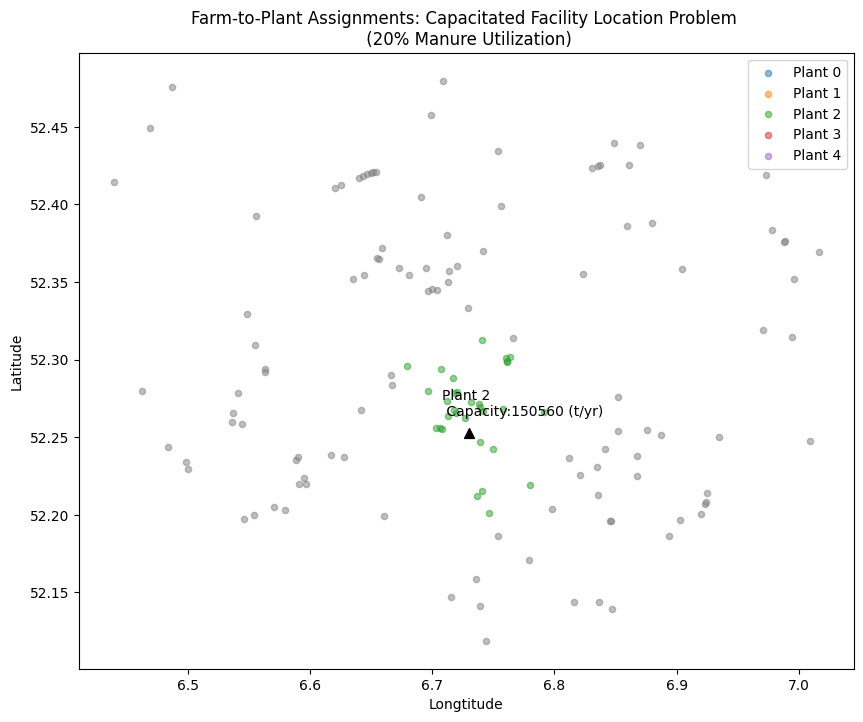

In [334]:
# Visualize the results
plt.figure(figsize=(10, 8))

# Plot farms in solution
for j in Plant:
    assigned = assigned_farms[j]
    plt.scatter([farm.loc[i, 'x'] for i in assigned], [farm.loc[i, 'y'] for i in assigned], label=f"Plant {j}", marker='o', s=20, alpha=0.5)

# Plot farms excluded in solution
for i in farm_not_in_solution:
    plt.scatter(farm.loc[i, 'x'], farm.loc[i, 'y'], marker='o', s=20, c='Grey', alpha=0.5)

# Plot plants in solution
for i in plant_in_use:
    plt.scatter(potential_digester_location.loc[i, 'x'], potential_digester_location.loc[i, 'y'], marker="^", s=50, c='Black')
    label = f"Plant {i} \n Capacity:{potential_digester_location.loc[i, 'capacity']} (t/yr)"
    plt.annotate(label, # this is the text
                 (potential_digester_location.loc[i, 'x'], potential_digester_location.loc[i, 'y']), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(-20,10), # distance from text to points (x,y)
                 ha='left', va='bottom') # horizontal alignment can be left, right or center

# for i, (x_val, y_val) in enumerate(zip(x, y)):
#     label = f'Point {i+1} ({x_val}, {y_val})'  # Create a label for each data point
#     plt.annotate(label, (x_val, y_val), textcoords="offset points", xytext=(0, 10), ha='center')


# scatter = plt.scatter(potential_digester_location['x'], potential_digester_location['y'], c=potential_digester_location['capacity'], label="Plant Locations", marker='s', s=50)
# Add labels based on 'Label' column
# for i, row in potential_digester_location.iterrows():
#     plt.annotate(row['capacity'], (row['x'], row['y']), textcoords="offset points", xytext=(0, 10), ha='center')

# Add labels and legend
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.title("Farm-to-Plant Assignments: Capacitated Facility Location Problem \n (20% Manure Utilization)")
plt.legend()
# legend = plt.legend(*scatter.legend_elements(), loc='upper left', bbox_to_anchor=(1.0, 1.0))

# # Create a dictionary to map unique values to custom legend labels
# custom_labels = {'A': 'Category 1', 'B': 'Category 2', 'C': 'Category 3'}

# # Replace unique values with custom labels for the legend
# legend_labels = [custom_labels[label] for label in df['Label'].unique()]

# # Create the legend with custom labels
# legend = plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.savefig(r"./cflp_v1_20%manure_relaxed.png", dpi=300)

plt.show()

In [333]:
# Print Optimal
print("Total Cost = ", value(prob.objective))

Total Cost =  257520.25842174856
